<a href="https://colab.research.google.com/github/sengpakliew-maker/Portfolio/blob/main/IMC_text_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os
uploaded = files.upload()
os.makedirs('images', exist_ok=True)
for name in uploaded.keys():
    with open(os.path.join('images', name), 'wb') as f:
        f.write(uploaded[name])

Saving image 1.jpg to image 1.jpg
Saving image 2.jpg to image 2.jpg
Saving image 3.jpg to image 3.jpg
Saving image 4.jpg to image 4.jpg
Saving image 5.jpg to image 5.jpg
Saving image 6.jpg to image 6.jpg
Saving image 7.jpg to image 7.jpg
Saving image 8.jpg to image 8.jpg
Saving image 9.jpg to image 9.jpg
Saving image 10.jpg to image 10.jpg
Saving image 11.jpg to image 11.jpg
Saving image 12.jpg to image 12.jpg
Saving image 13.jpg to image 13.jpg


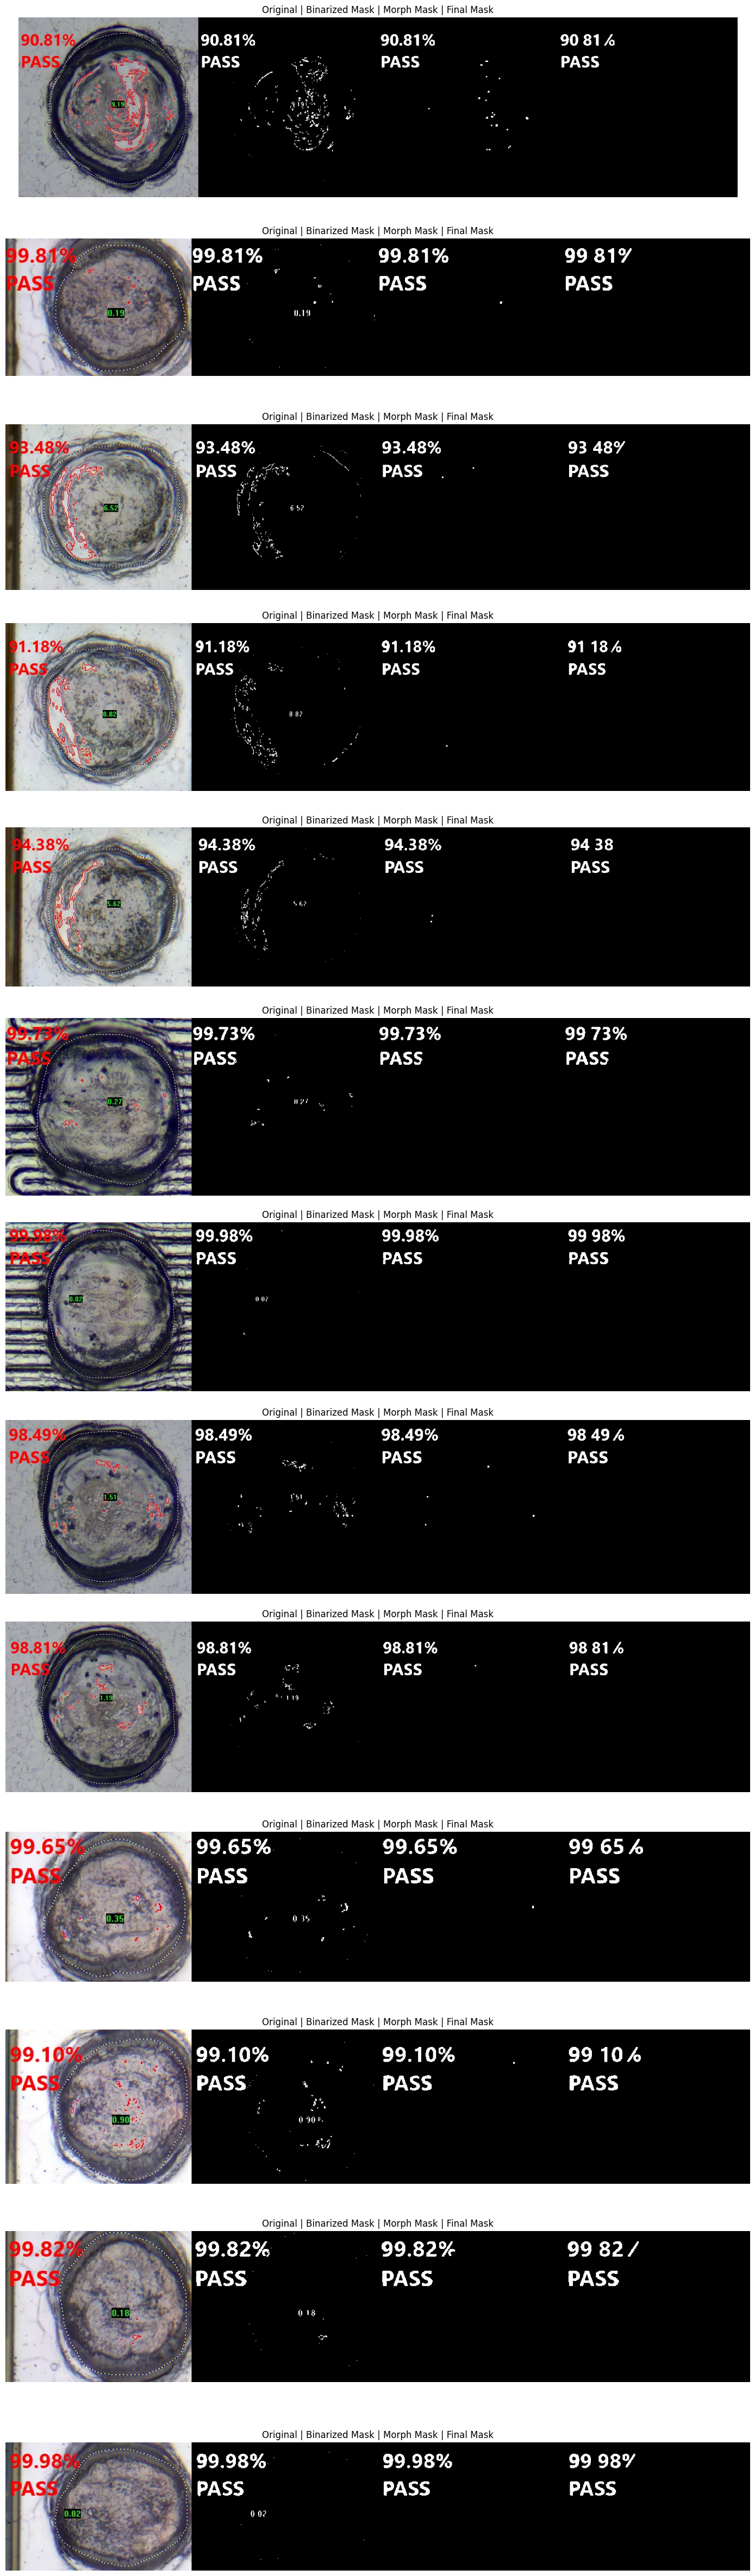

In [3]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

folder_path = "/content/images"
out_mask_folder = os.path.join(folder_path, "masks")
os.makedirs(out_mask_folder, exist_ok=True)

# red colour range
lower1 = np.array([0, 150, 150]); upper1 = np.array([10, 255, 255])
lower2 = np.array([10, 150, 150]); upper2 = np.array([179, 255, 255])

kernel_size = 3
open_iter = 1
close_iter = 0
area_threshold = 100

def get_clean_mask(img_bgr,lower1, upper1, lower2, upper2,kernel_size, open_iter, close_iter,area_threshold):
    # HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # mask
    m1 = cv2.inRange(hsv, lower1, upper1)
    m2 = cv2.inRange(hsv, lower2, upper2)
    raw_mask = cv2.bitwise_or(m1, m2)
    # opening to prevent large background area, closeing not needed
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel, open_iter)
    # mask_close = cv2.morphologyEx(raw_mask, cv2.MORPH_CLOSE, kernel, close_iter)

    # area filtering
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    final_mask = np.zeros_like(mask)
    for lbl in range(1, num_labels):
        area = stats[lbl, cv2.CC_STAT_AREA]
        if area >= area_threshold:
            final_mask[labels == lbl] = 255
    return raw_mask, mask, final_mask

image_files = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))  # need to save as png otherwise cant chop the image, supect pixel value problem

plt.figure(figsize=(14, 48))
show_i = 0
for idx, path in enumerate(image_files):
    name = os.path.basename(path)
    img_bgr = cv2.imread(path)
    raw_mask, mask, final_mask = get_clean_mask(
        img_bgr, lower1, upper1, lower2, upper2, kernel_size, open_iter, close_iter, area_threshold
    )

    # Save mask
    mask_save_path = os.path.join(out_mask_folder, os.path.splitext(name)[0] + " mask.png")
    cv2.imwrite(mask_save_path, final_mask)
    # plot image, convert to bgr to have same array dimension for hstack display
    raw_bgr = cv2.cvtColor(raw_mask, cv2.COLOR_GRAY2BGR)
    morph_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    final_bgr = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)
    combined = np.hstack([cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),raw_bgr, morph_bgr, final_bgr])
    plt.subplot(len(image_files), 1, show_i + 1)
    plt.imshow(combined)
    plt.title("Original | Binarized Mask | Morph Mask | Final Mask")
    plt.axis("off")
    show_i += 1

plt.tight_layout()
plt.show()

In [6]:
# chop the number
masks_folder = "/content/images/masks"
out_crops = "/content/images/crops_number"
os.makedirs(out_crops, exist_ok=True)

pad = 0

# sort the comp base on y position and followed by x position
def sort_text(comp):
    rows = []
    for b in comp:
        placed = False
        y_coor = b["y"]
        for row in rows:
            last_y = row[-1]["y"]
            if abs(y_coor - last_y) <= 5:
                row.append(b);
                placed = True;
                break
        if not placed:
            rows.append([b])
    rows_sorted = sorted(rows, key=lambda r: np.mean([it["y"] for it in r]))
    rows_final = [sorted(r, key=lambda it: it["x"]) for r in rows_sorted][0]
    return rows_final

# gather mask files
mask_files = []
mask_files += sorted(glob.glob(os.path.join(masks_folder, "*.png")))

global_index = 0

for mask_path in mask_files:
    mask_name = os.path.splitext(os.path.basename(mask_path))[0]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # text components info
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    comps = []
    for lbl in range(1, num_labels):
        x, y, w, h, area = stats[lbl]
        comps.append({
            "label": lbl, "x": int(x), "y": int(y), "w": int(w), "h": int(h)})

    # sort the text
    text = sort_text(comps)

    # take the first 4
    ordered_limited = text[0:4]

    # save crops
    for i, comp in enumerate(ordered_limited):
        global_index += 1
        order_str = f"{global_index:04d}"
        x, y, w, h = comp["x"], comp["y"], comp["w"], comp["h"]
        x0 = x - pad
        y0 = y - pad
        x1 = x + w + pad
        y1 = y + h + pad
        crop = mask[y0:y1, x0:x1]

        out_name = f"{order_str}__{mask_name}.png"
        out_path = os.path.join(out_crops, out_name)
        cv2.imwrite(out_path, crop)
        print('saaved as', out_name)

saaved to 0001__image 1 mask.png
saaved to 0002__image 1 mask.png
saaved to 0003__image 1 mask.png
saaved to 0004__image 1 mask.png
saaved to 0005__image 10 mask.png
saaved to 0006__image 10 mask.png
saaved to 0007__image 10 mask.png
saaved to 0008__image 10 mask.png
saaved to 0009__image 11 mask.png
saaved to 0010__image 11 mask.png
saaved to 0011__image 11 mask.png
saaved to 0012__image 11 mask.png
saaved to 0013__image 12 mask.png
saaved to 0014__image 12 mask.png
saaved to 0015__image 12 mask.png
saaved to 0016__image 12 mask.png
saaved to 0017__image 13 mask.png
saaved to 0018__image 13 mask.png
saaved to 0019__image 13 mask.png
saaved to 0020__image 13 mask.png
saaved to 0021__image 2 mask.png
saaved to 0022__image 2 mask.png
saaved to 0023__image 2 mask.png
saaved to 0024__image 2 mask.png
saaved to 0025__image 3 mask.png
saaved to 0026__image 3 mask.png
saaved to 0027__image 3 mask.png
saaved to 0028__image 3 mask.png
saaved to 0029__image 4 mask.png
saaved to 0030__image 4 mas

In [11]:
# Zip chop number and download
import shutil
base_name = out_crops.rstrip("/\\")
zip_path = shutil.make_archive(base_name, 'zip', out_crops)
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#import the template
uploaded = files.upload()
os.makedirs('templates_digits', exist_ok=True)

# Save uploaded files into images/
for name in uploaded.keys():
    # uploaded[name] is bytes; write to file
    with open(os.path.join('templates_digits', name), 'wb') as f:
        f.write(uploaded[name])

Saving 0.png to 0.png
Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png
Saving 8.png to 8.png
Saving 9.png to 9.png


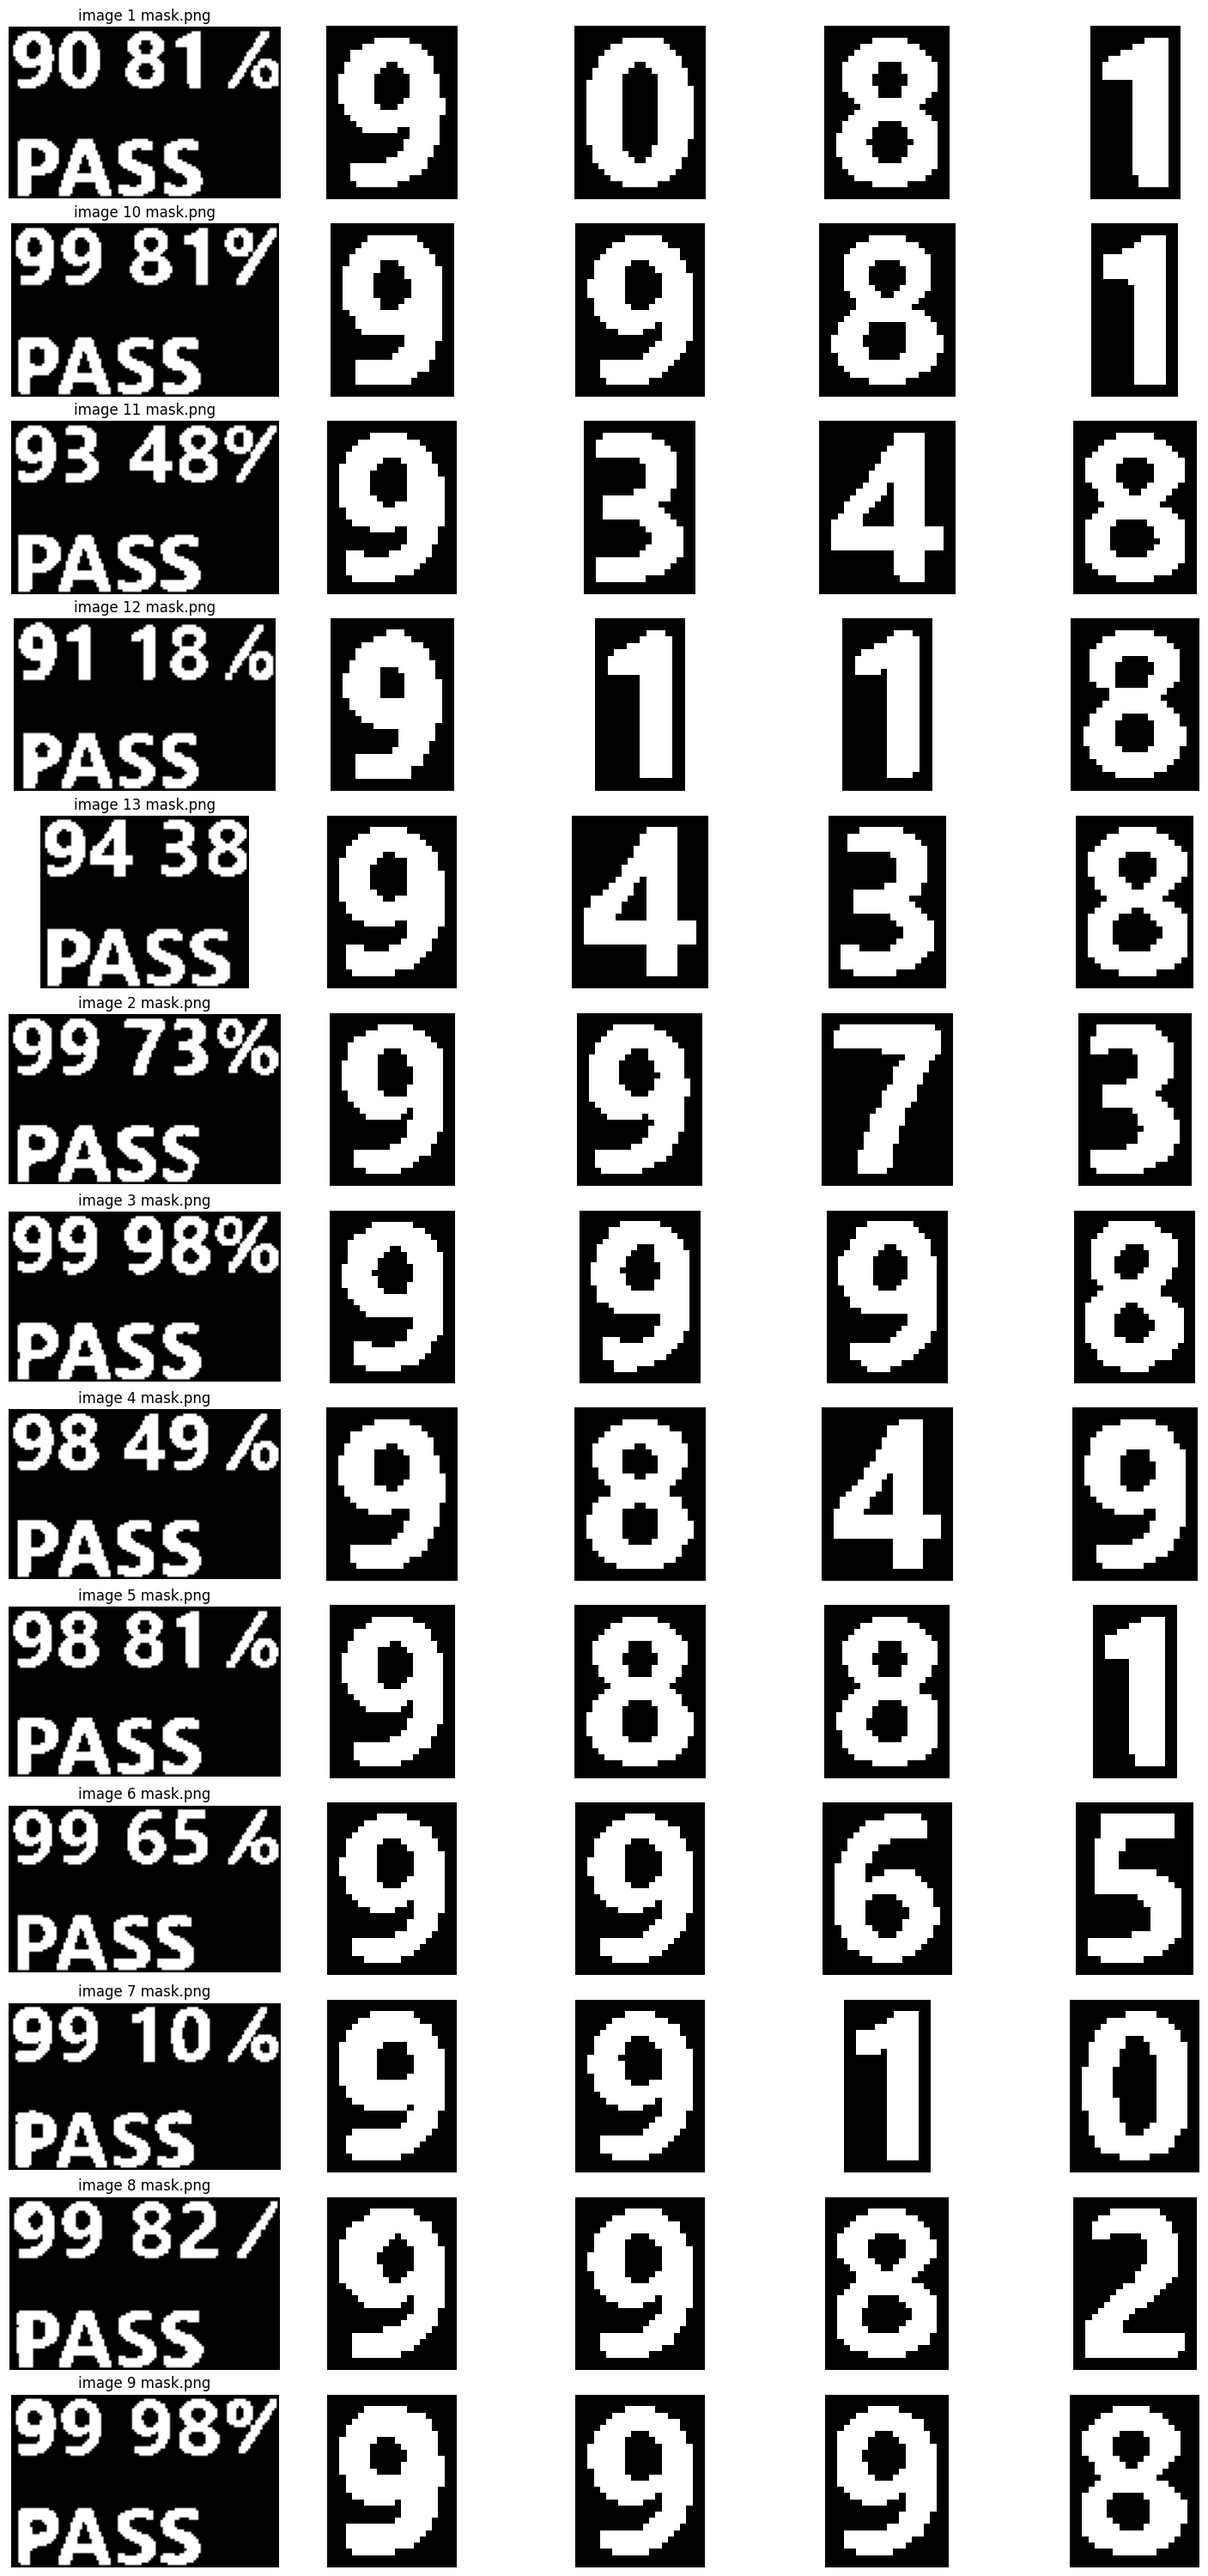

In [8]:
# Displays chopped number
masks_folder = "/content/images/masks"

pad = 2
# sort the number
def sort_text(comp):
    rows = []
    for b in comp:
        placed = False
        y_coor = b["y"]
        for row in rows:
            last_y = row[-1]["y"]
            if abs(y_coor - last_y) <= 5:
                row.append(b);
                placed = True;
                break
        if not placed:
            rows.append([b])
    rows_sorted = sorted(rows, key=lambda r: np.mean([it["y"] for it in r]))
    rows_final = [sorted(r, key=lambda it: it["x"]) for r in rows_sorted][0]
    return rows_final


mask_files = sorted(glob.glob(os.path.join(masks_folder, "*.png")))

fig_rows = len(mask_files)
fig_cols = 5
plt.figure(figsize=(15,30))

summary = []
for i, mask_path in enumerate(mask_files):
    name = os.path.basename(mask_path)
    img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    ys, xs = np.where(img > 0)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x2 = x0 - pad; x3 = x1 + pad
    y2 = y0 - pad; y3 = y1 + pad
    roi = img[y2:y3, x2:x3]

    # image info
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(roi, connectivity=8)
    comps = []
    for lbl in range(1, num_labels):
        x,y,w,h,area = stats[lbl]
        comps.append({"x":x,"y":y,"w":w,"h":h})
    rows = sort_text(comps)
    flat_row_4 = rows[:4]
    # plot
    plt_idx = i*fig_cols + 1
    plt.subplot(fig_rows, fig_cols, plt_idx)
    plt.imshow(roi, cmap='gray'); plt.title(f"{name}"); plt.axis('off')

    # crops
    for j in range(4):
        plt_idx = i*fig_cols + 2 + j
        plt.subplot(fig_rows, fig_cols, plt_idx)
        c = flat_row_4[j]
        cx0 = c['x'] - pad
        cy0 = c['y'] - pad
        cx1 = c['x'] + c['w'] + pad
        cy1 = c['y'] + c['h'] + pad
        crop = roi[cy0:cy1, cx0:cx1]
        plt.imshow(crop, cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()

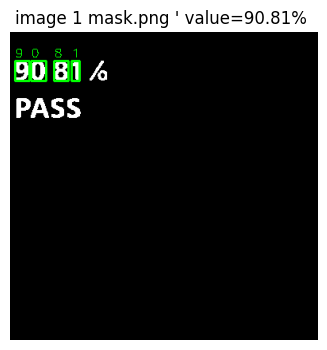

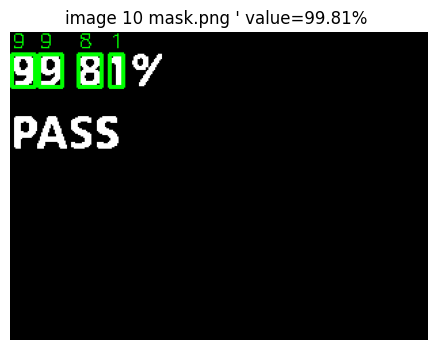

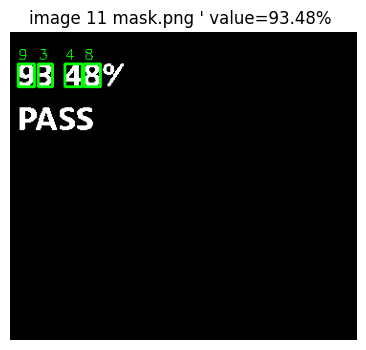

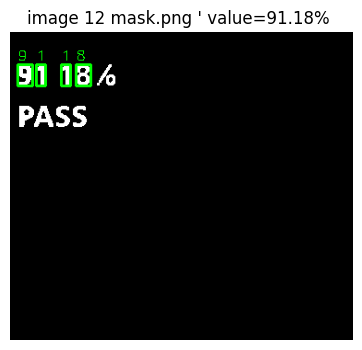

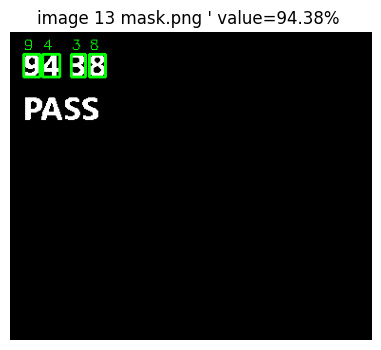

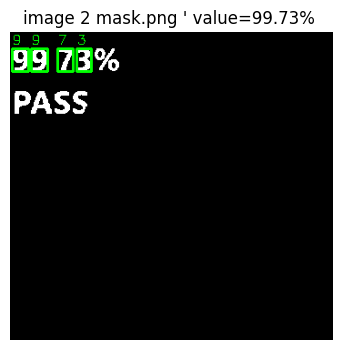

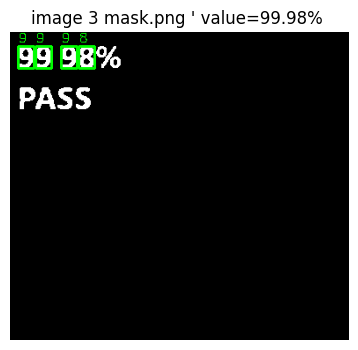

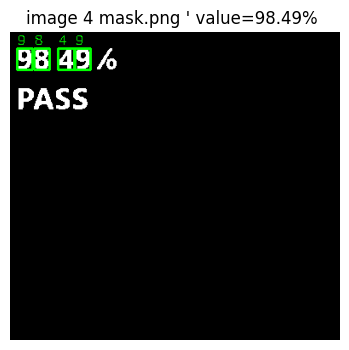

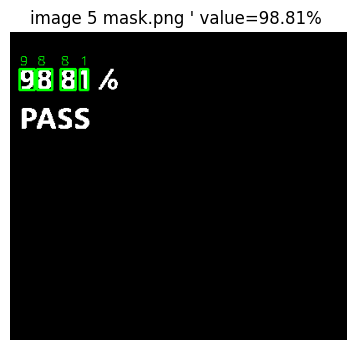

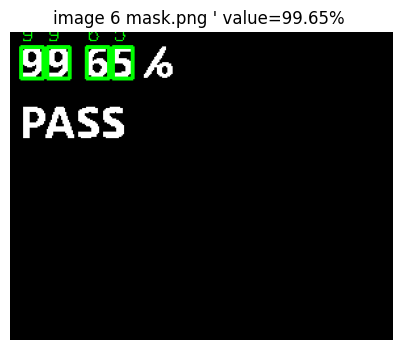

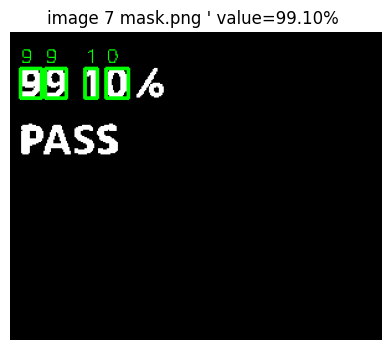

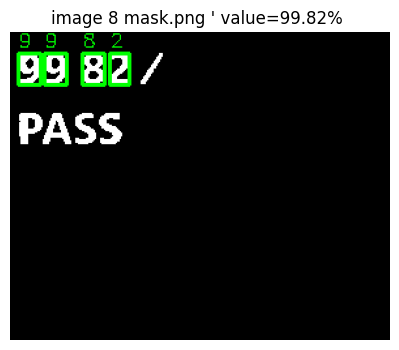

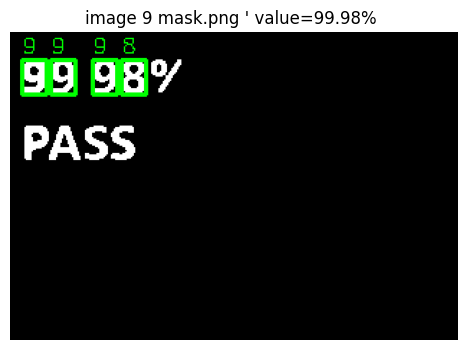


Average IMC% = 97.32%


In [9]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
# template matching and calculate the average IMC
masks_folder = "/content/images/masks"
templates_folder = "/content/templates_digits"

# parameter
match_method = cv2.TM_CCOEFF_NORMED
thresholds = 0.65
nms_iou_thresh = 0.15

# get mean height of the number that later used to scale the size of template
def median_component_height(img):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    heights = []
    comps = []
    for lbl in range(1, num_labels):
        x, y, w, h, area = stats[lbl]
        comps.append({"x":x,"y":y,"w":w,"h":h,"area":area})
    comps_sorted = sorted(comps, key=lambda it: it["x"])
    # the number and string 'pass' have the same height but the '%' is difference. Sort the x position first and take the first 4 to prevent take the height of '%'
    first4 = comps_sorted[:4]
    h_values = [c["h"] for c in first4]
    mean_h = float(np.mean(h_values))
    return mean_h

# Return list of (x,y,score) local peaks in result >= thresh
def find_peaks_in_result(res, thresh):
    peaks_mask = (res >= thresh)
    ys, xs = np.where(peaks_mask)
    return [(xs[i], ys[i], res[ys[i], xs[i]]) for i in range(len(xs))]

# Calculate the IOU for NMS
def rect_iou(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    ax2, ay2 = ax+aw, ay+ah
    bx2, by2 = bx+bw, by+bh
    ix1 = max(ax, bx); iy1 = max(ay, by)
    ix2 = min(ax2, bx2); iy2 = min(ay2, by2)
    if ix2 <= ix1 or iy2 <= iy1:
        return 0
    inter = (ix2-ix1)*(iy2-iy1)
    union = aw*ah + bw*bh - inter
    return inter/union

# Non-Maximum Suppression removes duplicates and keep the winner
def nms_rects(rects, iou_thresh):
    rects = sorted(rects, key=lambda r: r['score'], reverse=True)
    keep = []
    for r in rects:
        skip = False
        for k in keep:
            if rect_iou((r['x'], r['y'], r['w'], r['h']), (k['x'], k['y'], k['w'], k['h'])) > iou_thresh:
                skip = True
                break
        if not skip:
            keep.append(r)
    return keep

def covert_digit_format(digits_str):
    digits_str = ''.join(digits_str)
    first_2 = digits_str[:-2]
    last_2 = digits_str[-2:]
    return float(first_2 + "." + last_2)

# Load templates 0 - 9
templates = {}
for d in range(10):
    path = os.path.join(templates_folder, f"{d}.png")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    templates[d] = img
# Gather mask files
mask_files = sorted(glob.glob(os.path.join(masks_folder, "*.png")))
results = []

for mask_path in mask_files:
    name = os.path.basename(mask_path)
    img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    H_img, W_img = img.shape

    # compute median component height for this image
    med_h = median_component_height(img)

    # Collect candidates across digits and template scales
    candidates = []
    for d, tmpl_orig in templates.items():
        th_h0, th_w0 = tmpl_orig.shape
        # compute template required scale to match image-digit median height
        scale_required = float(med_h) / float(th_h0)
        # new template size
        new_h = int(round(th_h0 * scale_required))
        new_w = int(round(th_w0 * scale_required))
        tmpl_scaled = cv2.resize(tmpl_orig, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        res = cv2.matchTemplate(img, tmpl_scaled, match_method)
        peaks = find_peaks_in_result(res, thresholds)
        for (px, py, score) in peaks:
              candidates.append({
                'x': int(px), 'y': int(py), 'w': int(new_w), 'h': int(new_h),
                'score': float(score), 'label': int(d), 'scale': float(scale_required)})

    # NMS across all candidate
    winner = nms_rects(candidates,nms_iou_thresh)

    # sort the winner
    filtered = []
    if winner:
        rows = []
        for b in winner:
            placed = False
            y_coor = b['y']
            for row in rows:
                last_y = row[-1]['y']
                if abs(y_coor - last_y) <= 15:
                    row.append(b)
                    placed = True
                    break
            if not placed:
                rows.append([b])
        rows_sorted = sorted(rows, key=lambda r: np.mean([it['y'] for it in r]))
        filtered = [sorted(r, key=lambda it: it['x']) for r in rows_sorted][0]
        #lowest = min(rows_final[0], key=lambda b: b['score']) #check the min score
        #print("min score =", lowest['score'], "label =", lowest['label'])
    # Draw boxes
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # convert to BGR to draw colored rectangles
    for r in filtered:
        x, y, w, h = r['x'], r['y'], r['w'], r['h']
        cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_bgr, str(r['label']), (x, y - 5),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # join first 4 digit
    join_digit = ''.join(str(r['label']) for r in filtered)
    value = covert_digit_format(join_digit[:4])
    results.append({'file': name, 'digits': join_digit, 'value_percent': value})

    # Show inline
    plt.figure(figsize=(8,4))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    title_val = f"{name} ' value={'{:.2f}%'.format(value) if value is not None else 'N/A'} "
    plt.title(title_val)
    plt.axis('off')

# average
plt.show()
vals = [r['value_percent'] for r in results]
avg = sum(vals) / len(vals)
print(f"\nAverage IMC% = {avg:.2f}%")